### Question 2

You are provided with returns data for an equity long/short hedge fund and several common factors in the 'returns data' sheet of the excel. Rana is interested i this particular fund and asks you to perform some analysis on its returns.

2.1

- Fit a multilinear regression model to the data, calculating the fund's alpha and betas. Perform any steps you believe are necessary to produce the best model, detailing them as you go along.

2.2

- Evaluate your model.

2.3

- Tyler is sceptical about investing in this fund. He thinks it might be more profitable for us to simply invest in the underlying factors and save on any performance and management fees applied by the fund manager. Using your model, determine which would be the most profitable strategy. Calculate the sharpe ratio for each.

2.4

- Following on from this, which strategy (investing in the fund vs. investing in the factor portfolio) is more risky? Perform any calculations you need to answer this question.

2.5

- Are the betas you calculated stationary? Perform any calculation/analysis necessary and comment on what impact this may have from a risk point of view.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import norm

In [2]:
data = pd.read_excel('data.xlsx', 'returns data').set_index('perf_date').sort_index() # set and sort date index, as some dates were not in order
data.head()

,Hedge Fund,Factor - Low Risk,Factor - Value vs Growth,Factor - Fixed Income Carry,Factor - Local Equity,Factor - Trend Following,Factor - Commodities,Factor - Equity,Factor - Foreign Exchange Carry,Factor - Small Cap,Factor - Emerging Markets,Factor - Foreign Currency,Factor - Local Inflation,Factor - Equity Short Volatility,Factor - Credit,Factor - Interest Rates,Factor - Crowding,Factor - Momentum,Factor - Quality
perf_date,,,,,,,,,,,,,,,,,,,
2006-01-31,0.0088,-0.027273,-0.012632,0.006403,-0.004653,0.027924,-0.003037,0.028032,-0.003735,0.025687,0.022615,-0.028750,0.009925,0.008125,0.019915,-0.006530,0.0,0.030207,-0.000626
2006-02-28,0.0083,0.036038,0.012010,-0.021316,0.012622,0.008689,-0.021246,0.005813,-0.005763,-0.005889,0.023366,0.005920,-0.005564,0.016747,0.003766,-0.002498,0.0,-0.014214,-0.002882
2006-03-31,0.0242,0.000317,-0.001646,-0.006682,0.012469,0.026956,-0.002117,0.013999,-0.057169,0.012512,-0.039254,0.004665,0.015684,0.005389,0.000358,-0.014418,0.0,0.008646,0.009902
2006-04-30,0.0146,-0.003192,0.002147,0.020273,0.004506,0.064467,0.006392,0.013055,0.005360,-0.007250,-0.006414,-0.021774,0.026725,0.006107,0.008849,-0.013622,0.0,0.017130,0.008526
2006-05-31,-0.0325,0.015825,0.019188,0.029589,-0.011379,-0.026691,0.006959,-0.052638,-0.012393,-0.015368,-0.054605,-0.036699,0.016301,0.006757,-0.000345,0.005999,0.0,0.001438,-0.001415


In [3]:
risk_free_rate = 0.0

data['Hedge Fund'] = data['Hedge Fund'] - risk_free_rate # assuming risk-free rate at 0.0%

### 2.1 Fit a multilinear regression model to the data, calculating the fund's alpha and betas. Perform any steps you believe are necessary to produce the best model, detailing them as you go.

In [4]:
data.corr() # check for high correlations, as multi-colinearity may give unreliable results

,Hedge Fund,Factor - Low Risk,Factor - Value vs Growth,Factor - Fixed Income Carry,Factor - Local Equity,Factor - Trend Following,Factor - Commodities,Factor - Equity,Factor - Foreign Exchange Carry,Factor - Small Cap,Factor - Emerging Markets,Factor - Foreign Currency,Factor - Local Inflation,Factor - Equity Short Volatility,Factor - Credit,Factor - Interest Rates,Factor - Crowding,Factor - Momentum,Factor - Quality
Hedge Fund,1.000000,-0.024927,-0.048101,-0.004061,-0.156394,0.054090,-0.088907,0.001151,-0.074095,-0.107134,-0.144234,0.020700,-0.030761,0.015351,0.049089,-0.176183,0.110470,0.409925,0.133020
Factor - Low Risk,-0.024927,1.000000,-0.086396,0.045135,0.149089,0.126751,-0.089632,-0.051626,0.033418,-0.278203,0.022839,0.004737,0.038391,0.289356,0.058657,-0.065920,0.161648,0.191939,0.424708
Factor - Value vs Growth,-0.048101,-0.086396,1.000000,-0.259556,-0.014384,0.086868,0.096861,0.004056,0.056231,0.095479,-0.064863,-0.071523,0.120977,-0.003920,0.023495,-0.005627,-0.027572,-0.102296,-0.153180
Factor - Fixed Income Carry,-0.004061,0.045135,-0.259556,1.000000,0.159187,-0.049021,0.178503,0.009932,0.093110,0.066472,0.204874,0.067517,0.035830,0.074400,0.056503,0.105612,-0.000611,0.092505,-0.011232
Factor - Local Equity,-0.156394,0.149089,-0.014384,0.159187,1.000000,0.210257,0.165195,-0.190090,-0.032624,-0.145678,0.040904,0.420015,0.061357,0.045377,0.074735,0.006741,0.124350,-0.128706,-0.001902
Factor - Trend Following,0.054090,0.126751,0.086868,-0.049021,0.210257,1.000000,-0.012120,-0.143745,-0.030539,-0.211222,-0.262335,0.215863,-0.054881,-0.014385,-0.081780,0.090216,0.088582,0.341440,0.204376
Factor - Commodities,-0.088907,-0.089632,0.096861,0.178503,0.165195,-0.012120,1.000000,0.089681,0.333121,0.205211,0.122118,-0.120451,0.208041,0.109390,0.219311,0.142380,0.121304,0.012241,-0.319389
Factor - Equity,0.001151,-0.051626,0.004056,0.009932,-0.190090,-0.143745,0.089681,1.000000,0.063126,0.310245,0.047333,-0.147879,0.042962,0.059952,0.531483,-0.184606,0.034661,-0.099333,-0.243943
Factor - Foreign Exchange Carry,-0.074095,0.033418,0.056231,0.093110,-0.032624,-0.030539,0.333121,0.063126,1.000000,0.082668,0.156421,-0.021250,0.201990,0.086076,0.041017,0.129530,-0.077350,-0.067684,-0.170936
Factor - Small Cap,-0.107134,-0.278203,0.095479,0.066472,-0.145678,-0.211222,0.205211,0.310245,0.082668,1.000000,0.267203,-0.129742,0.043733,0.036950,0.307682,0.057124,-0.171837,-0.288150,-0.500447


#### Take a look at the data, to see the if there are any outliers

In [5]:
data.describe()

,Hedge Fund,Factor - Low Risk,Factor - Value vs Growth,Factor - Fixed Income Carry,Factor - Local Equity,Factor - Trend Following,Factor - Commodities,Factor - Equity,Factor - Foreign Exchange Carry,Factor - Small Cap,Factor - Emerging Markets,Factor - Foreign Currency,Factor - Local Inflation,Factor - Equity Short Volatility,Factor - Credit,Factor - Interest Rates,Factor - Crowding,Factor - Momentum,Factor - Quality
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.008426,0.005162,150.222145,0.000084,-0.000999,0.005613,-0.001761,0.006200,-0.000083,-0.002021,-0.002571,0.001120,0.002171,0.001245,0.000228,165.289979,0.002219,0.005333,0.006526
std,0.029623,0.028541,2569.592858,0.019464,0.021516,0.026661,0.020470,0.040760,0.020065,0.018025,0.020904,0.018551,0.022432,0.018643,0.027555,1725.936406,0.009019,0.032067,0.015723
min,-0.096051,-0.128207,-12739.631010,-0.075152,-0.081331,-0.072346,-0.060501,-0.149934,-0.063892,-0.090379,-0.125790,-0.038892,-0.085123,-0.052001,-0.170308,-0.028068,-0.052240,-0.127459,-0.040496
25%,-0.009950,-0.011406,-0.015540,-0.010146,-0.014698,-0.010551,-0.013445,-0.014444,-0.010376,-0.011469,-0.013991,-0.010622,-0.008966,-0.009227,-0.009373,-0.003997,-0.000932,-0.011822,-0.001276
50%,0.008800,0.004758,-0.000972,0.001565,-0.000484,0.003492,-0.001189,0.012433,0.001187,-0.001049,-0.000205,0.000475,0.000509,0.004018,0.003766,0.002805,0.001267,0.007850,0.007147
75%,0.028000,0.023451,0.011636,0.011342,0.012546,0.020816,0.011129,0.028201,0.013087,0.009227,0.010226,0.011589,0.012679,0.012631,0.017425,0.009257,0.007310,0.024615,0.014936
max,0.087900,0.076999,31963.201493,0.065239,0.056810,0.102276,0.058252,0.115115,0.071994,0.069783,0.037207,0.067272,0.081401,0.040368,0.057066,23213.711045,0.028112,0.124979,0.084840


Immediate we see Value vs Growth & Interest Rate Factors have extreme values. We can also see the distribution of outliers using a boxplot (below). Given the limited amount of data, we'd rather not simply delete outliers, but set them to the feature medians (averages are influenced by outliers).

We will identify outliers as being 1.5 IQR away from the 25% percentile, and 1.5 IQR away from the 75% percentile.

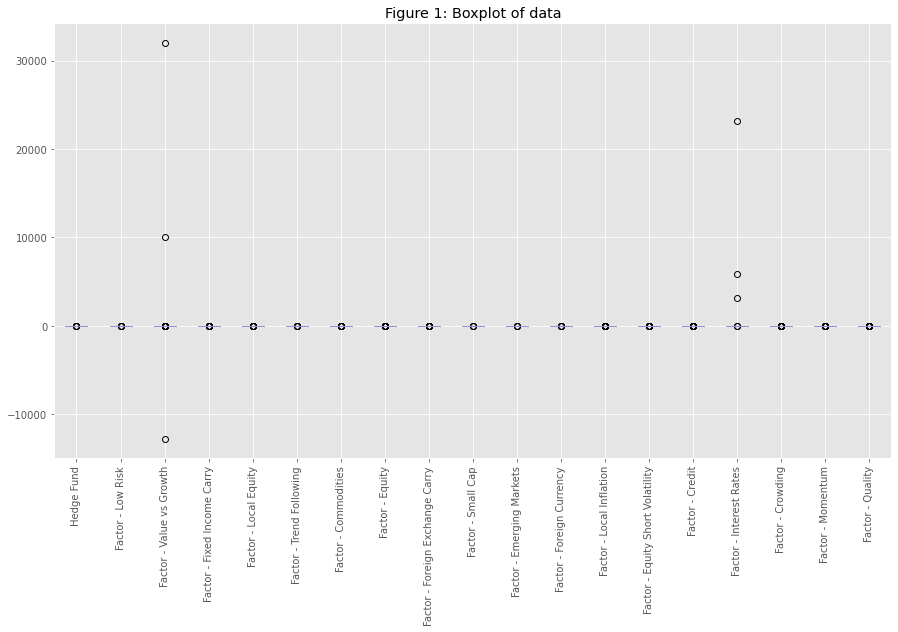

In [6]:
ax = data.boxplot(figsize = (15, 8))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Figure 1: Boxplot of data')
plt.show()

We can clearly see the extreme values for Value vs Growth and Interest Rates. For the sake of visualisation, let's exclude them from the boxplot to see the distribution data for the other features.

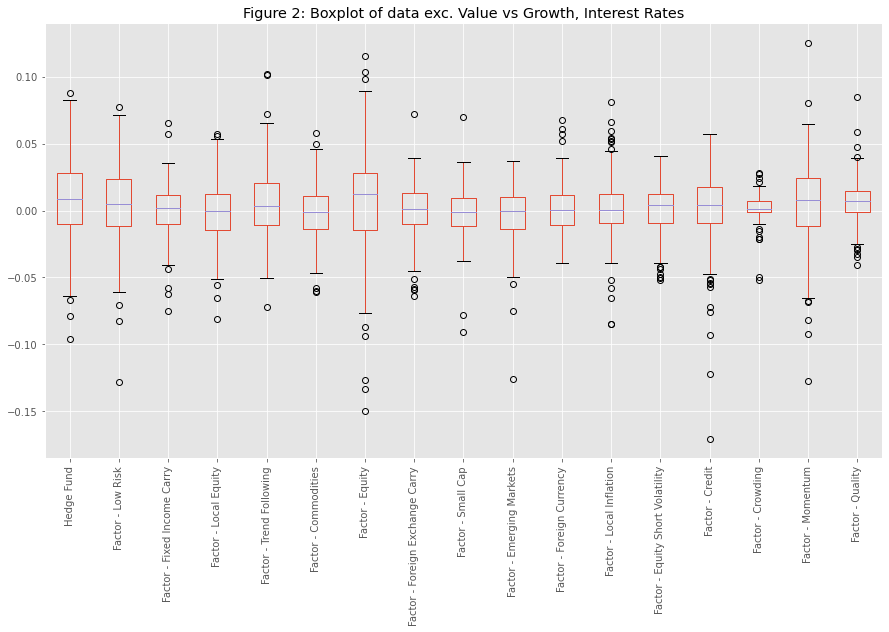

In [7]:
ax = data.loc[:,~data.columns.isin(['Factor - Value vs Growth', 'Factor - Interest Rates'])].boxplot(figsize = (15, 8))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Figure 2: Boxplot of data exc. Value vs Growth, Interest Rates')
plt.show()


There are still outliers in the other features. Let's deal with these with the interquartile range method.

In [8]:
def replace_outliers_with_median(df):
    
    # Calculate IQR for each column
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds for each column
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    # Identify outliers in each column
    outliers = ((df < lower_bound) | (df > upper_bound))

    # Replace outliers with column median
    df_clean = df.copy()
    for column in df.columns:
        column_median = df[column].median()
        df_clean[column][outliers[column]] = column_median

    return df_clean

In [9]:
data = replace_outliers_with_median(data)

In [10]:
data.describe()

,Hedge Fund,Factor - Low Risk,Factor - Value vs Growth,Factor - Fixed Income Carry,Factor - Local Equity,Factor - Trend Following,Factor - Commodities,Factor - Equity,Factor - Foreign Exchange Carry,Factor - Small Cap,Factor - Emerging Markets,Factor - Foreign Currency,Factor - Local Inflation,Factor - Equity Short Volatility,Factor - Credit,Factor - Interest Rates,Factor - Crowding,Factor - Momentum,Factor - Quality
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.009395,0.006306,-0.001753,0.000733,-0.000550,0.004640,-0.001428,0.008112,0.001073,-0.001532,-0.001266,-0.000087,0.001602,0.003067,0.004540,0.002368,0.002764,0.006807,0.006700
std,0.026820,0.025021,0.019111,0.016226,0.018946,0.023666,0.018298,0.033069,0.016955,0.015105,0.017783,0.016499,0.015338,0.016151,0.018351,0.009687,0.005440,0.026245,0.011854
min,-0.063500,-0.060933,-0.052004,-0.040396,-0.051438,-0.050146,-0.046890,-0.076223,-0.045338,-0.037960,-0.049915,-0.038892,-0.039474,-0.038840,-0.047664,-0.021461,-0.010257,-0.065447,-0.024968
25%,-0.009450,-0.009916,-0.014168,-0.009484,-0.012240,-0.010324,-0.013030,-0.009725,-0.008563,-0.011438,-0.013274,-0.010622,-0.007391,-0.007331,-0.006428,-0.003911,-0.000189,-0.004116,-0.000639
50%,0.008800,0.004758,-0.000972,0.001565,-0.000484,0.003492,-0.001189,0.012433,0.001187,-0.001049,-0.000205,0.000475,0.000509,0.004018,0.003766,0.002805,0.001267,0.007850,0.007147
75%,0.027750,0.023265,0.009453,0.010906,0.011670,0.019665,0.010472,0.027101,0.012699,0.008863,0.010226,0.010269,0.009930,0.012631,0.017425,0.008740,0.006906,0.024208,0.014370
max,0.082600,0.071215,0.050441,0.035691,0.053179,0.065530,0.046090,0.089393,0.039235,0.036146,0.037207,0.039461,0.044356,0.040368,0.057066,0.028664,0.018067,0.064791,0.039219


In [11]:
# Multilinear Regression, with alpha term

fund_returns = data[data.columns[0]]
factor_returns = data[data.columns[1:]]

X = factor_returns
y = fund_returns

# Add a constant column to account for the alpha term
X = sm.add_constant(X)

# Fit the multilinear model
model = sm.OLS(y, X)
results = model.fit()

# Evaluate the alpha term (constant)
alpha = results.params['const']
alpha_pvalue = results.pvalues['const']

# Print the regression results
print(f"Alpha: {round(alpha, 5)}")
print(f"Alpha p-value: {round(alpha_pvalue, 5)}")

Alpha: 0.00756
Alpha p-value: 0.00115


/Users/robertblomqvist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:
ols_res_pd = pd.DataFrame(results.params, columns = ['Value'])
ols_res_pd['p_values'] = results.pvalues.T
ols_res_pd

,Value,p_values
const,0.007558,0.001152
Factor - Low Risk,0.022559,0.807201
Factor - Value vs Growth,-0.588727,0.000001
Factor - Fixed Income Carry,0.042870,0.698119
Factor - Local Equity,-0.022420,0.834936
Factor - Trend Following,-0.034935,0.660873
Factor - Commodities,0.023782,0.822686
Factor - Equity,-0.016175,0.796359
Factor - Foreign Exchange Carry,-0.072516,0.509519
Factor - Small Cap,-0.263082,0.052418


In [13]:
print('The R^2 of the model is:', round(results.rsquared, 5))

The R^2 of the model is: 0.30188


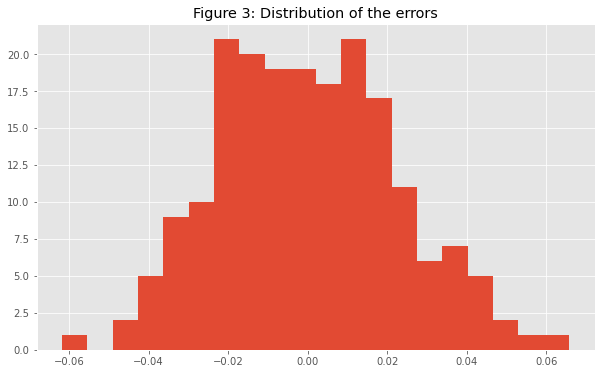

In [14]:
(results.predict(X) - y).hist(bins = 20, figsize =(10,6))
plt.title('Figure 3: Distribution of the errors')
plt.show()

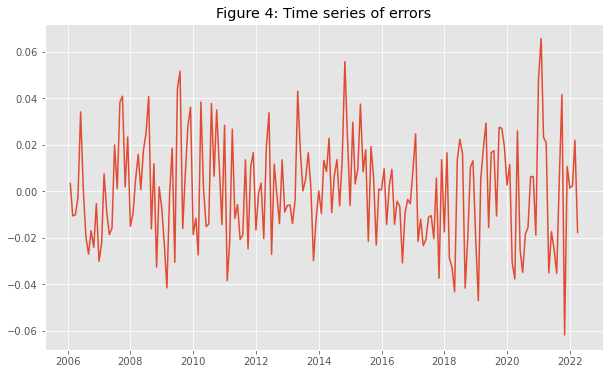

In [15]:
plt.figure(figsize = (10,6))
plt.plot(results.predict(X) - y)
plt.title('Figure 4: Time series of errors') # Doesnt look like there is a seasonality aspect or anyting else
plt.show()

The hedge fund's alpha is ~0.00756 on a monthly basis, when accounting for the 18 risk factors and the alpha has a very low p-value, indicating that it's alpha is significant. This means that the the ~ 0.00756 monthly return of the hedge fund cannot be explained from the 18 risk factors. This is a significant value indicating the manager's skill.

The fund has low p-values to the Value vs Growth factor, Small Cap factor, Credit factor, Emerging Markets and Momentum  factor. These make sense in terms of it being a L/S equity fund.

Let's try and simplyify the model by only using these 5 factors. An important note here is that we will be setting the intercept (alpha) term to 0, as we will be foregoing this manager skill by investing in the factors directly, and this is something that cannot be replicated.

In [16]:
# Select the 5 factors
X_2 = factor_returns[['Factor - Value vs Growth', 'Factor - Small Cap',
                      'Factor - Credit','Factor - Emerging Markets', 'Factor - Momentum']]
y_2 = fund_returns

# Fit the model
model_2 = sm.OLS(y_2, X_2)
results_2 = model_2.fit()

In [17]:
ols_res_pd_2 = pd.DataFrame(results_2.params, columns = ['Value'])
ols_res_pd_2['p_values'] = round(results_2.pvalues.T, 6)
ols_res_pd_2

,Value,p_values
Factor - Value vs Growth,-0.556548,0.000001
Factor - Small Cap,-0.228385,0.056616
Factor - Credit,0.354525,0.000119
Factor - Emerging Markets,-0.195394,0.042438
Factor - Momentum,0.197849,0.013284


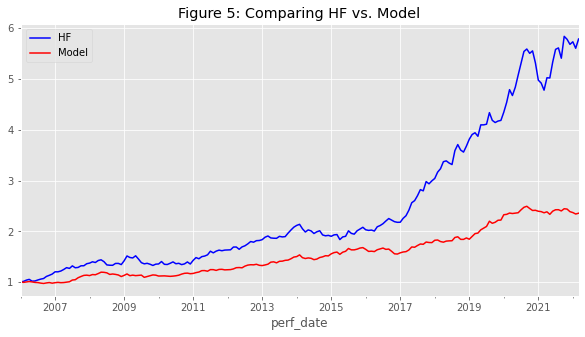

In [18]:
model_2 = (X_2@np.array(results_2.params).T)

plt.figure(figsize = (10, 5))
(1+fund_returns).cumprod().plot(color = 'blue')
(1+model_2).cumprod().plot(color = 'red')
plt.title('Figure 5: Comparing HF vs. Model')
plt.legend(['HF', 'Model'])
plt.show()

### 2.2 Evaluate your model


In [19]:
ols_res_pd_2

,Value,p_values
Factor - Value vs Growth,-0.556548,0.000001
Factor - Small Cap,-0.228385,0.056616
Factor - Credit,0.354525,0.000119
Factor - Emerging Markets,-0.195394,0.042438
Factor - Momentum,0.197849,0.013284


In [20]:
print('The R^2 of the new model is:', round(results_2.rsquared, 5))

The R^2 of the new model is: 0.3253


From the table above, we see that the p-values of all the factors are significant at the 10% level, and 4 out of the 5 are significant at the 5% level. Only the Small Cap factor fails at the 5% level (p-value = 0.056616)

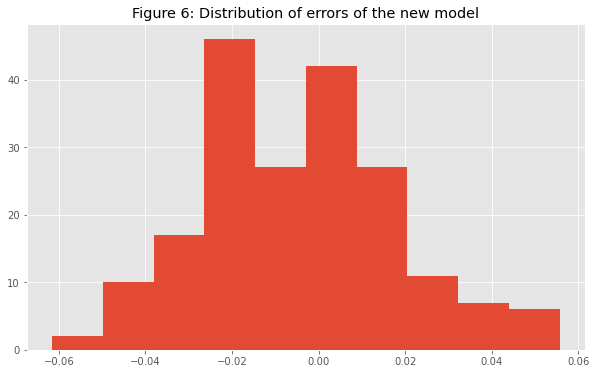

In [21]:
(results_2.predict(X_2) - y).hist(bins = 10, figsize =(10,6))
plt.title('Figure 6: Distribution of errors of the new model')
plt.show()

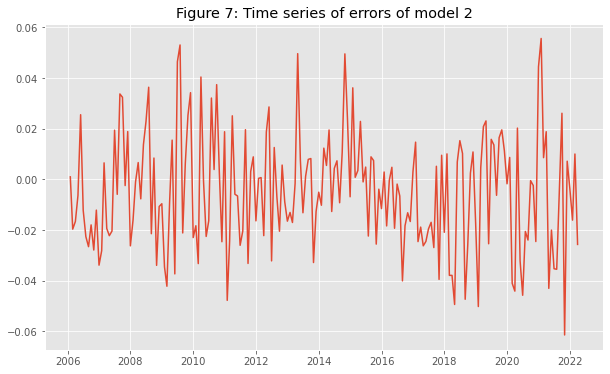

In [22]:
plt.figure(figsize = (10,6))
plt.plot(results_2.predict(X_2) - y)
plt.title('Figure 7: Time series of errors of model 2') # Doesnt look like there is a seasonality aspect or anyting else
plt.show()

### 2.3 Tyler is sceptical about investing in this fund. He thinks it might be more profitable for us to simply invest in the underlying factors and save on any performance and management fees applied by the fund manager. Using your model, determine which would be the most profitable strategy. Calculate the sharpe ratio for each.


In [23]:
def sharpe_ratio(returns, rf = 0, interval = 12):
    return (returns.mean() - rf) / returns.std() * np.sqrt(interval)

hf_sharpe = sharpe_ratio(fund_returns, risk_free_rate, 12)
model_2_sharpe = sharpe_ratio(model_2, risk_free_rate, 12)

print('hf sharpe:', round(hf_sharpe, 3))
print('model_2 sharpe:', round(model_2_sharpe, 3))

hf sharpe: 1.214
model_2 sharpe: 1.008


The hegde fund had a monthly alpha of ~ 0.0076, which is very high (on a geometric basis this is ~9.5% annualised), it will be difficult to beat this. That being said, the hedge fund has a sharpe ratio of 1.214, versus the (in-sample) sharpe ratio of the model of 1.008.

However, the hedge fund would be taking a 1-2% management fee, accompanied by a performance fee (say, 20%). Let's simplyfy the calculation to be: 2% annualised management fee (0.167% monthly), and 20% on any positive performance and see how the returns look.

At the same time, let's apply a 20 bp annual fee to the new model, as we can expect these factors could be replicated by some ETFs.

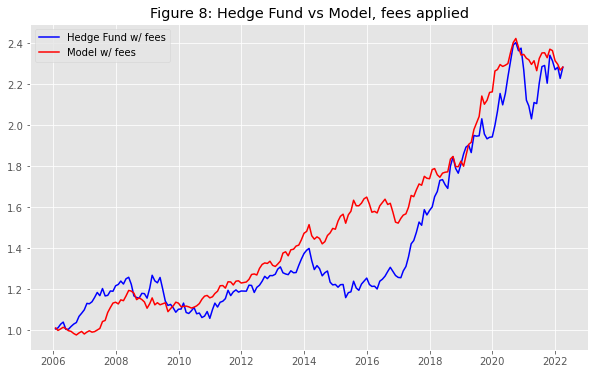

In [24]:
fund_returns_fees = pd.Series(np.where(fund_returns > 0, fund_returns * 0.8, fund_returns) - 0.02 / 12, index = data.index)
model_2_fees = model_2 - 0.002 / 12

plt.figure(figsize = (10, 6))
plt.plot((1 + fund_returns_fees).cumprod(), color = 'blue')
plt.plot((1 + model_2_fees).cumprod(), color = 'red')
plt.legend(['Hedge Fund w/ fees', 'Model w/ fees'])
plt.title('Figure 8: Hedge Fund vs Model, fees applied')
plt.show()

In [25]:
fund_sharpe_fees = sharpe_ratio(fund_returns_fees)
model_sharpe_fees = sharpe_ratio(model_2_fees)
print('The sharpe ratio of the hedge fund after fees is:', round(fund_sharpe_fees, 5))
print('The sharpe ratio of the model after fees is:', round(model_sharpe_fees, 5))

The sharpe ratio of the hedge fund after fees is: 0.66691
The sharpe ratio of the model after fees is: 0.97094


The figure above shows something interesting: after applying fees, the model actually performs much better relatively to before, where the hedge fund's sharpe ratio has now been cut to 0.67, whereas the sharpe ratio of the factor model is 0.97.

### 2.4 Following on from this, which strategy (investing in the fund vs. investing in the factor portfolio) is more risky? Perform any calculations you need to answer this question.

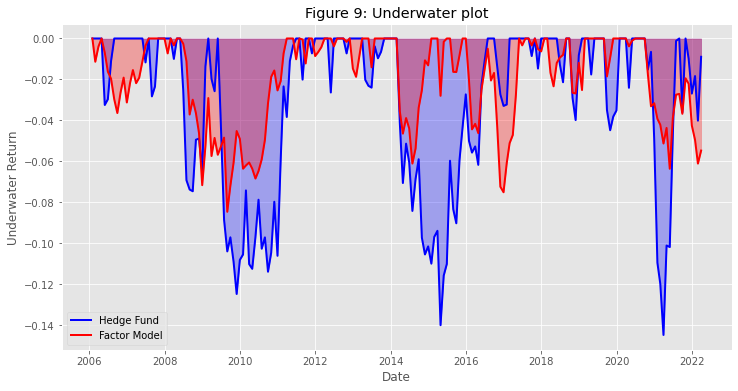

Max drawdown of the Hedge Fund is: -0.14488
Max drawdown of the Factor Model is: -0.08469


In [26]:
def underwater_func(returns):
    cumulative_returns = np.cumprod(1 + returns)  # Calculate cumulative returns
    underwater = (cumulative_returns / np.maximum.accumulate(cumulative_returns)) - 1

    return underwater

uw_fund = underwater_func(fund_returns)
uw_factor = underwater_func(model_2)

plt.figure(figsize = (12, 6))
plt.plot(data.index, uw_fund, color = 'blue', lw = 2)
plt.fill_between(data.index, uw_fund, color = 'blue', alpha = 0.3)
plt.plot(data.index, uw_factor, color = 'red', lw = 2)
plt.fill_between(data.index, uw_factor, color = 'red', alpha = 0.3)
plt.legend(['Hedge Fund', 'Factor Model'])
plt.xlabel('Date')
plt.ylabel('Underwater Return')
plt.title('Figure 9: Underwater plot')
plt.show()

print('Max drawdown of the Hedge Fund is:', round(min(uw_fund), 5))
print('Max drawdown of the Factor Model is:', round(min(uw_factor), 5))

In [27]:
# Function to assess the maximum length of consecutive 0s in an array
def non_zero_seq(array):
    
    max_length = 0
    curr_length = 0

    for num in array:
        if num != 0:
            curr_length += 1
            max_length = max(max_length, curr_length)
        else:
            curr_length = 0

    return max_length

drawdown_len_fund = non_zero_seq(uw_fund)
drawdown_len_factor = non_zero_seq(uw_factor)

In [28]:
### Looking at Value at Risk, Conditional Value at Risk

def calculate_var_cvar(returns, confidence_level):
    sorted_returns = np.sort(returns)
    num_returns = len(sorted_returns)
    index = int(num_returns * (1 - confidence_level))

    var = sorted_returns[index]
    cvar = np.mean(sorted_returns[:index])

    return var, cvar

def calculate_var_cvar_normal(returns, confidence_level):
    
    mean_return = np.mean(returns)
    std_dev = np.std(returns)

    z_score = norm.ppf(1 - confidence_level)
    var = mean_return + z_score * std_dev
    cvar = mean_return - (std_dev / (1 - confidence_level)) * norm.pdf(z_score)

    return var, cvar

confidence_level = 0.95

var_hf, cvar_hf = calculate_var_cvar(fund_returns, confidence_level)
var_factor, cvar_factor = calculate_var_cvar(model_2, confidence_level)

var_hf_normal, cvar_hf_normal = calculate_var_cvar_normal(fund_returns, confidence_level)
var_factor_normal, cvar_factor_normal = calculate_var_cvar_normal(model_2, confidence_level)

In [29]:
### Summary statistics

risk_pd = pd.DataFrame(index = ['Std', 'Max Loss', 'Max DD', 'Longest Trough (mths)',
                                'VaR_95', 'CVaR_95', 'VaR_95_norm', 'CVaR_95_norm'],
                       columns = ['Hedge Fund', 'Factor Model'])

risk_pd.loc['Std', 'Hedge Fund'] = fund_returns.std()
risk_pd.loc['Std', 'Factor Model'] = model_2.std()
risk_pd.loc['Max Loss', 'Hedge Fund'] = fund_returns.min()
risk_pd.loc['Max Loss', 'Factor Model'] = model_2.min()
risk_pd.loc['Max DD', 'Hedge Fund'] = min(uw_fund)
risk_pd.loc['Max DD', 'Factor Model'] = min(uw_factor)
risk_pd.loc['Longest Trough (mths)', 'Hedge Fund'] = drawdown_len_fund
risk_pd.loc['Longest Trough (mths)', 'Factor Model'] = drawdown_len_factor

risk_pd.loc['VaR_95', 'Hedge Fund'] = var_hf
risk_pd.loc['VaR_95', 'Factor Model'] = var_factor
risk_pd.loc['CVaR_95', 'Hedge Fund'] = cvar_hf
risk_pd.loc['CVaR_95', 'Factor Model'] = cvar_factor
risk_pd.loc['VaR_95_norm', 'Hedge Fund'] = var_hf_normal
risk_pd.loc['VaR_95_norm', 'Factor Model'] = var_factor_normal
risk_pd.loc['CVaR_95_norm', 'Hedge Fund'] = cvar_hf_normal
risk_pd.loc['CVaR_95_norm', 'Factor Model'] = cvar_factor_normal

risk_pd

,Hedge Fund,Factor Model
Std,0.02682,0.015564
Max Loss,-0.0635,-0.038087
Max DD,-0.144876,-0.084685
Longest Trough (mths),28,33
VaR_95,-0.0361,-0.024409
CVaR_95,-0.045947,-0.029744
VaR_95_norm,-0.034606,-0.021005
CVaR_95_norm,-0.045784,-0.027492


From the table above, we see that all but one of the risk parameters are in favour of the factor model. (NB: these are calculated on gross return numbers, and the factor model still outperforms).

The monthly standard deviation of returns of the hedge fund are 2.68%, and 1.56% for the factor model, and the hedge fund has a maximum monthly loss of 6.35%, compared to the 3.81% of the factor model. The maximum drawdown of the hedge fund was -14.5%, while it was -8.47% for the factor model. However, the factor model has a 5 month longer longest trough (33 vs. 28).

In terms of Value at Risk (VaR) and Conditional Value at Risk (CVaR/ES), we calculated these on two bases; namely non-parametric (actual returns) and parametric (assuming normal distribution of returns).

In the non-parametric formulation, the hedge fund had a monthly 95% VaR of -3.61% (meaning that 5% of the time, the loss would be greater than 3.61%), while the factor model's was 2.44%. The CVaR here was -4.59% for the hedge fund (meaning that, given a loss of worse than 95% of the distribution, ie. the average loss in the tail, the average loss was -4.59%%). This was -2.97% for the factor model.

Under normality assumptions (VaR_95_norm, CVaR_95_norm), we reach the same conclusions: hedge fund monthly VaR at 95% is calculated at -3.46% (which equals -12.5% on an annual basis: $-3.4606\% \cdot \sqrt{12}$). For the factor model the values are -2.44%, -8.46%.

This shows that the hedge fund is riskier.

Additional risks include liquidity risk, for example. The cost of getting out of the hedge fund investment may be high, as exiting the investment may 1) take time (introducing market risk on exit- the market may move against you as you are exiting), 2) may carry a fee in itself. In the case of the factor model (let's say managedby ETFs), the liquidity risk is much smaller (of course depending on the choice of ETFs). An added benefit of ETFs is the daily NAV (as opposed to lower frequency hedge fund data), and the lower management fees in the case of passive ETFs which could track a factor.

### 2.5 Are the betas you calculated stationary? Perform any calculation/analysis necessary and comment on what impact this may have from a risk point of view.

In [30]:
ols_res_pd_2

,Value,p_values
Factor - Value vs Growth,-0.556548,0.000001
Factor - Small Cap,-0.228385,0.056616
Factor - Credit,0.354525,0.000119
Factor - Emerging Markets,-0.195394,0.042438
Factor - Momentum,0.197849,0.013284


The betas (Values) and p-values above are for the factor model used Value vs Growth, Small Cap, Credit, EM, and Momentum factors, which are much more stable than the ones originally calculated when assessing the hedge fund's alpha. This is seen by the low p-values, where 4 of the 5 factors are significant (at the 5% level), and 1 (Small Cap) is significant at the 10% level (p-value: 0.0566).

Another way to assess the betas and p-values would be to perform a train/test split, where we would iterate the timeperiod forward, calculate the betas and p-values until the last dataset (with a fixed window, for example). We could then visually see the stability of the betas.

The risk impact of non-stationary betas is that the exposures may change over time (or even in the following out-of-sample), hence the factor model would not be replicating the hedge fund going forward.